# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [4]:
!pip install gdown

In [5]:
import gdown
gdown.download('https://drive.google.com/file/d/1KKd6J29mFn3WEoXN4_lX631hkkB5uME5/view?usp=sharing', output='celeba.zip', fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1KKd6J29mFn3WEoXN4_lX631hkkB5uME5
From (redirected): https://drive.google.com/uc?id=1KKd6J29mFn3WEoXN4_lX631hkkB5uME5&confirm=t&uuid=f32d96ff-58fb-4eac-9528-af3811ecdbe9
To: /content/celeba.zip
100%|██████████| 1.43G/1.43G [00:23<00:00, 61.2MB/s]


'celeba.zip'

Or you can download it manually from Yandex Disk https://disk.yandex.ru/d/QErNx-MoC-2Y6Q

In [6]:
!unzip celeba.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: celeba/celeba/img_align_celeba/057314.jpg  
  inflating: celeba/celeba/img_align_celeba/138950.jpg  
  inflating: celeba/celeba/img_align_celeba/117264.jpg  
  inflating: celeba/celeba/img_align_celeba/112606.jpg  
  inflating: celeba/celeba/img_align_celeba/053676.jpg  
  inflating: celeba/celeba/img_align_celeba/158869.jpg  
  inflating: celeba/celeba/img_align_celeba/170252.jpg  
  inflating: celeba/celeba/img_align_celeba/021665.jpg  
  inflating: celeba/celeba/img_align_celeba/174525.jpg  
  inflating: celeba/celeba/img_align_celeba/042747.jpg  
  inflating: celeba/celeba/img_align_celeba/165952.jpg  
  inflating: celeba/celeba/img_align_celeba/148026.jpg  
  inflating: celeba/celeba/img_align_celeba/015537.jpg  
  inflating: celeba/celeba/img_align_celeba/107859.jpg  
  inflating: celeba/celeba/img_align_celeba/127972.jpg  
  inflating: celeba/celeba/img_align_celeba/056173.jpg  
  inflating: celeba/

## Prepare the data

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [8]:
class CropCelebA64:

    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [9]:
# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

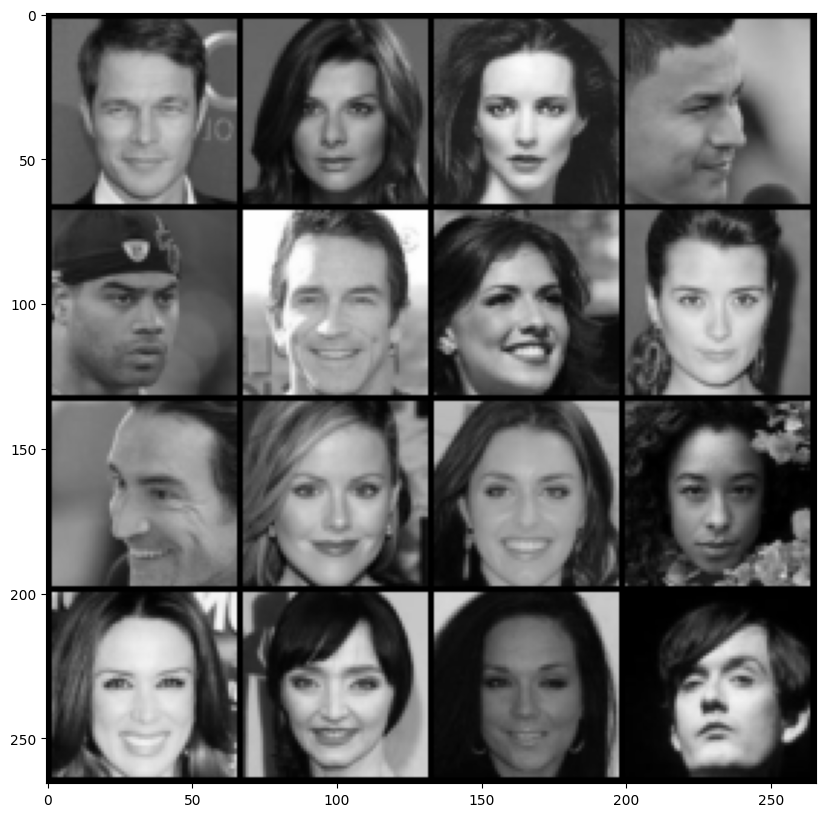

In [10]:
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

In [11]:
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Autoencoder(4 points)

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [12]:
dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


class Autoencoder(nn.Module):

    def __init__(self, latent_dim=100, input_dim=4096):
        super(Autoencoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, input_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)

    def encode(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        h1 = torch.relu(self.fc1(x))
        return self.fc2(h1)

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        flat_output = torch.sigmoid(self.fc4(h3))
        return flat_output.view(-1, self.channels, self.height, self.width)

    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code


In [13]:
from itertools import islice
def show_reconstruction(model, loader):
    images, _ = list(islice(loader, 1))[0]
    reconstruction, latent_code = model(images.to(device))

    reconstruction = reconstruction[:16].cpu()
    plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

In [ ]:

# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.003)

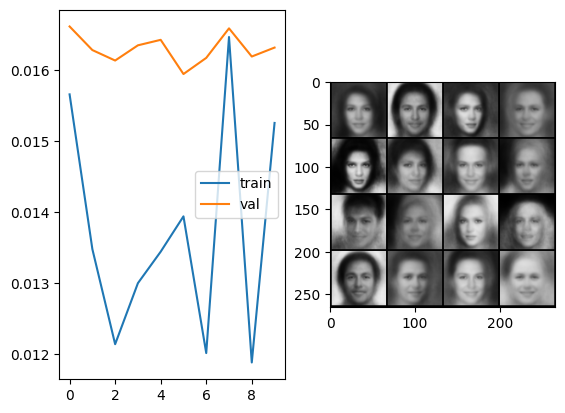

In [ ]:

# Train your autoencoder
# Visualize progress in reconstruction and loss decay
n_epoch = 10
train_losses, val_losses = [], []

for epoch in range(n_epoch):
    autoencoder.train()
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(data)
        loss = criterion(reconstruction, data)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    autoencoder.eval()
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstruction, latent_code = autoencoder(data)
            loss = criterion(reconstruction, data)

    val_losses.append(loss.item())

    display.clear_output(wait=True)
    plt.subplot(121)
    plt.plot(np.arange(len(train_losses)), train_losses, label='train')
    plt.plot(np.arange(len(val_losses)), val_losses, label='val')
    plt.legend()
    plt.subplot(122)
    show_reconstruction(autoencoder, val_loader)
    plt.show()

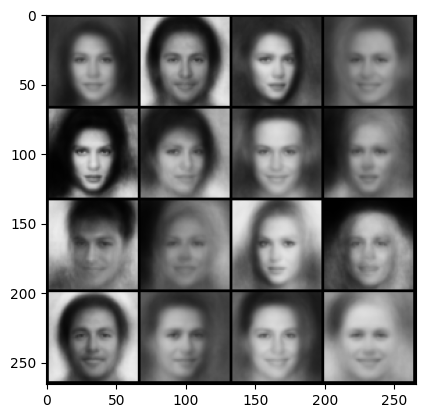

In [ ]:
# Examine the reconstructions
show_reconstruction(autoencoder, val_loader)

Reconstruction is not bad, right?

Реконструкция и в правду не так плоха, хотя фон просто размыт, но лица все же более четкие

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

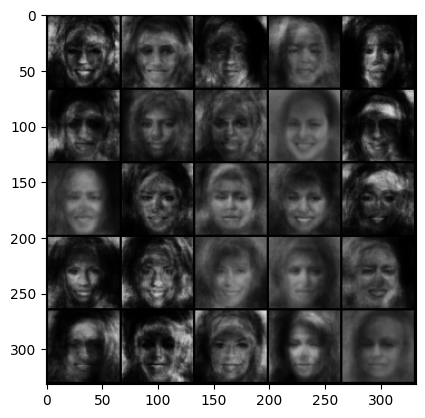

In [ ]:

z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decode(z.to(device)).clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

Страшилка какая-то... хотя и видны контуры лиц, но фон просто сплошное пятно. Выглядит как будто наложили кучи фоток одну на другую и получилось нечто

# Variational Autoencoder(6 points)

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [19]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid



class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(64*64, 400)
        self.fc2_mu = nn.Linear(400, latent_dim)
        self.fc2_logsigma = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4_mu = nn.Linear(400, 64*64)
        self.fc4_logsigma = nn.Linear(400, 64*64)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logsigma(h1)

    def reparameterize(self, mu, logsigma):
        std = torch.exp(logsigma)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        mu_x = torch.sigmoid(self.fc4_mu(h3))

        logsigma_x = self.fc4_logsigma(h3)
        logsigma_x = torch.clamp(logsigma_x, -5, 2)

        return mu_x, logsigma_x

    def forward(self, x):
        x = x.view(-1, 64*64)

        mu_z, logsigma_z = self.encode(x)
        z = self.reparameterize(mu_z, logsigma_z)
        mu_x, logsigma_x = self.decode(z)

        return mu_x, logsigma_x, mu_z, logsigma_z

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?


### Ответ на вопрос: "Why not sigma?"

1.  Область значений: Стандартное отклонение $\sigma$ по определению должно быть строго положительным ($\sigma > 0$). Выход обычного линейного слоя нейросети лежит в диапазоне $(-\infty, +\infty)$. Если мы будем предсказывать $\sigma$ напрямую, сеть может выдать отрицательное число.
    *   Предсказывая $a = \log \sigma$, мы можем получить любое число $a \in (-\infty, +\infty)$, и при этом $\sigma = e^a$ всегда будет положительной.
2.  Численная стабильность: При вычислениях часто нужны очень маленькие значения $\sigma$. Работать с логарифмами таких величин компьютеру проще избегается потеря точности около нуля, наверное.


In [28]:

def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp(), dim=1)


def log_likelihood(x, mu, logsigma):
    c = np.log(2 * np.pi)
    sigma_sq = (2 * logsigma_x).exp() # sigma^2

    return -0.5 * torch.sum(c + 2 * logsigma_x + (x - mu_x).pow(2) / sigma_sq, dim=1)


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    x = x.view(-1, 64*64)
    ll = log_likelihood(x, mu_gen, logsigma_gen)
    kl = KL_divergence(mu_z, logsigma_z)
    return torch.mean(kl - ll)



In [21]:
def show_reconstruction_vae(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        mu_gen, _, _, _ = model(images)
        reconstruction = mu_gen[:16].view(-1, 1, 64, 64).cpu().clamp(0, 1)
        plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
        plt.axis('off')

And train the model:

In [22]:
criterion = loss_vae
vae = VAE(latent_dim=dimZ).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

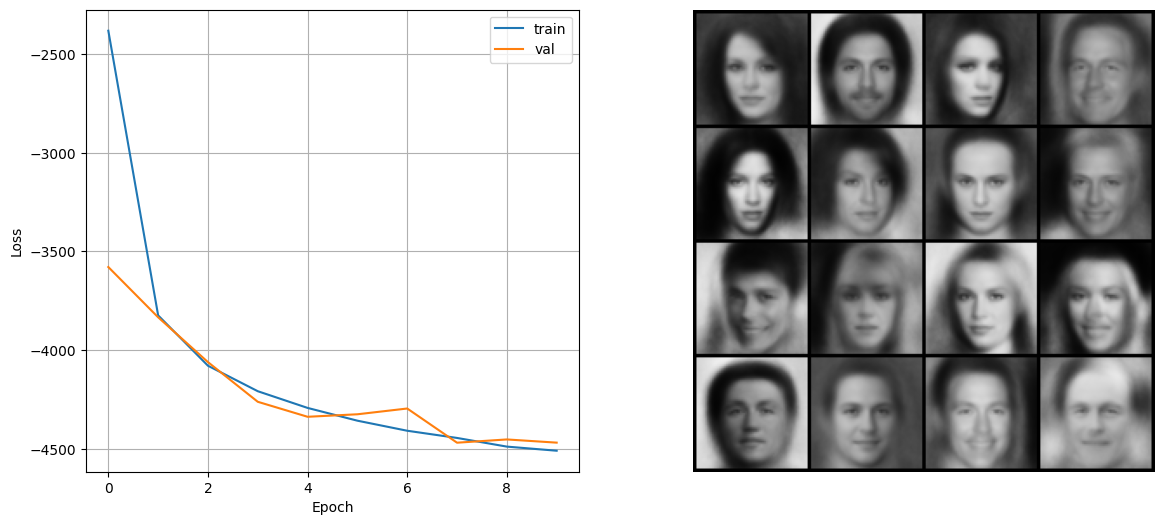

In [23]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# train your variational autoencoder
# visualize progress in reconstruction and loss decay
n_epoch = 10
train_losses, val_losses = [], []

for epoch in range(n_epoch):
    vae.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epoch} [Train]")

    for data, _ in pbar:
        data = data.to(device)

        optimizer.zero_grad()

        mu_x, logsigma_x, latent_mu, latent_logsigma = vae(data)
        flat_data = data.view(data.size(0), -1)

        loss = criterion(flat_data, mu_x, logsigma_x, latent_mu, latent_logsigma)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.2f}"})

    train_losses.append(running_loss / len(train_loader))

    vae.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            mu_x, logsigma_x, latent_mu, latent_logsigma = vae(data)

            flat_data = data.view(data.size(0), -1)

            loss = criterion(flat_data, mu_x, logsigma_x, latent_mu, latent_logsigma)
            running_val_loss += loss.item()

    val_losses.append(running_val_loss / len(val_loader))

    display.clear_output(wait=True)
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(122)
    show_reconstruction_vae(vae, val_loader)

    plt.show()



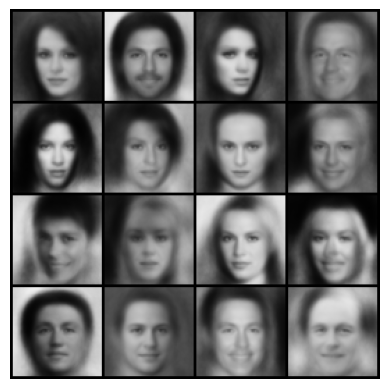

In [24]:
show_reconstruction_vae(vae, val_loader)

And finally sample from VAE.

Generating noise with dimension: 100


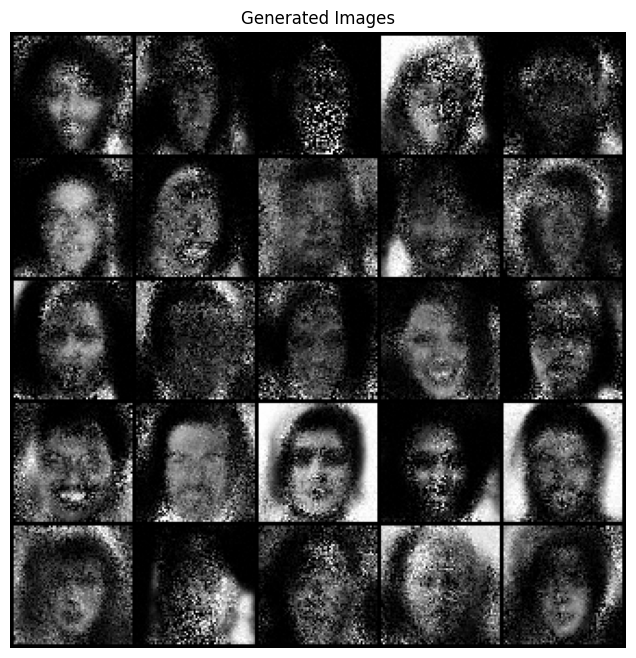

In [ ]:

# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

vae.eval()

with torch.no_grad():
    z_dim = vae.fc3.in_features
    print(f"Generating noise with dimension: {z_dim}")

    # 1) Sample z ~ N(0,1)
    z = torch.randn(25, z_dim).to(device)

    mu_gen, logsigma_gen = vae.decode(z)

    sigma_gen = torch.exp(logsigma_gen)
    eps = torch.randn_like(mu_gen)

    # Сэмплируем: x = mu + sigma * eps
    x_sampled = mu_gen + sigma_gen * eps

    reconstruction = x_sampled.view(-1, 1, 64, 64).cpu().clamp(0, 1)

    plt.figure(figsize=(8, 8))
    plt.title("Generated Images")
    plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
    plt.axis('off')
    plt.show()


Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now.

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

Генерация конечно... Нет слов одни эмоции, страшилка какая-то, все пиксельно и смазано.
